<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1  </center></h3>
<h4><center> Group Number: 13 </center></h4>
<h4><center> Group Member 1: Guan Qianyun, A0236097X </center></h4>
<h4><center> Group Member 2: Sun Shizhuo, A0236143M </center></h4>
<h4><center> Group Member 3: Feng Zhijing, A0235988H </center></h4>
<h4><center> Group Member 4: Shao Zihang, A0236062M </center></h4>


**Remark:** as described below, each group has to submit two documents on lumiNUS: 
1. a jupyter notebook with your code  
2. a pdf report explaining your approaches and conclusions.
3. you can have a look at `https://www.overleaf.com/read/xmvqgpsdqwyx` if you would like to use Overleaf and Latex to rapidly produce a neat report. You can use your NUS email to create an Overleaf account.

**File naming convention:**
1. the Jupyter notebook needs to be named `assignment_1_XX.ipynb`. For example, group number 3 needs to name its jupyter notebook as `assignment_1_03.ipynb`.
1. the pdf report needs to be named `assignment_1_XX.pdf`. For example, group number 3 needs to name its pdf report as `assignment_1_03.pdf`.



In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as jnp

import pylab as plt
import imageio
import os
import numpy as onp

# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
from sklearn import metrics

/Users/cainanguan/miniforge3/envs/jax_env/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Data Dowload
1. Download the "celeba_small.zip" file available on lumiNUS.
This is a 146Mo large zip-file containing 20K face images.
2. Download the attribute file "celeba.csv" available on lumiNUS.
3. Unzip the file "celeba_small.zip" in the directory of your choice. (Data = 175 Mo when uncompressed). 


# Brief Data exploration

In [ ]:
# mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#load attributes csv file
path_csv  = "/content/drive/MyDrive/data/"
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))


In [ ]:
#"attribute" is a dictionary containing several attributes for each image
attribute.keys()

Index(['Filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
!ls /content/drive/MyDrive/data

 assignment_1_celeba.ipynb      fashion_img_training.h5
 celeba.csv		        fashion_img_val.h5
 celeba.gsheet		        fashion_label_training.h5
 colab_data_loading.ipynb       fashion_label_val.h5
 colab_load_celeba.ipynb        img_celeba_small
 cropping.ipynb		        img_celeba_small.zip
'DSA4212 assignment1.ipynb'     shape_predictor_68_face_landmarks.dat
 DSA4212_Assignment1_v1.ipynb   week_5_logistic_regression_basic.ipynb


In [ ]:
!unzip /content/drive/MyDrive/data/img_celeba_small.zip  -d  /content/drive/MyDrive/data_assignment1/celeba

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/drive/MyDrive/data_assignment1/celeba/img_celeba_small/017501.jpg  
  inflating: /content/drive/MyDrive/data_assignment1/celeba/__MACOSX/img_celeba_small/._017501.jpg  
  inflating: /content/drive/MyDrive/data_assignment1/celeba/img_celeba_small/017502.jpg  
  inflating: /content/drive/MyDrive/data_assignment1/celeba/__MACOSX/img_celeba_small/._017502.jpg  
  inflating: /content/drive/MyDrive/data_assignment1/celeba/img_celeba_small/017503.jpg  
  inflating: /content/drive/MyDrive/data_assignment1/celeba/__MACOSX/img_celeba_small/._017503.jpg  
  inflating: /content/drive/MyDrive/data_assignment1/celeba/img_celeba_small/017504.jpg  
  inflating: /content/drive/MyDrive/data_assignment1/celeba/__MACOSX/img_celeba_small/._017504.jpg  
  inflating: /content/drive/MyDrive/data_assignment1/celeba/img_celeba_small/017505.jpg  
  inflating: /content/drive/MyDrive/data_assignment1/celeba/__MACOSX/img_celeba_small/._017505.jpg  
  inflating: /cont

In [ ]:
#let us list all the files in the image directory
path = "/content/drive/MyDrive/data_assignment1/celeba/img_celeba_small/"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


### Get Data From local files

In [ ]:
# Load CSV file
path_csv  = "/Users/cainanguan/Desktop/2022Spring/DSA4212_Optimisation/Assignment/Assign1/data"
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))
attribute.keys()

Index(['Filename', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')

In [ ]:
#Load images
path = "/Users/cainanguan/Desktop/2022Spring/DSA4212_Optimisation/Assignment/Assign1/data/img_celeba_small/"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")] # 保存jpg格式的文件名

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


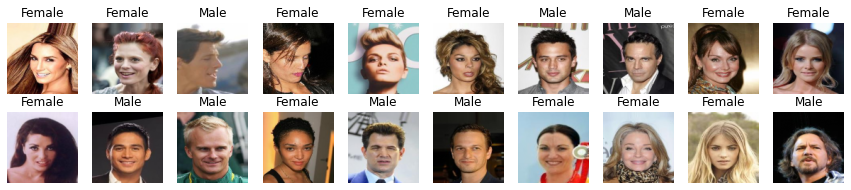

In [ ]:
#let us display the first 20 images
# !!! MAKE SURE THAT THE LABELS ARE CORRECT !!!
plt.figure(figsize=(15,3))
for k in range(20):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float) # 浮点数具有更高的精度和更丰富的计算表现力
    #resize to 100x100 for display (you do not have to do this in the assignment)
    im = resize(im, (100,100) )
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1) # 2行10列，从左到右，从上到下，第k+1个位置
    plt.imshow(im/255.) # 归一化，缩放到0-1的范围内
    plt.axis("off") # 隐藏当前子图的坐标轴和刻度线
    
    is_male = attribute["Male"][k]
    if is_male == 1:
        plt.title("Male")
    else:
        plt.title("Female")
    

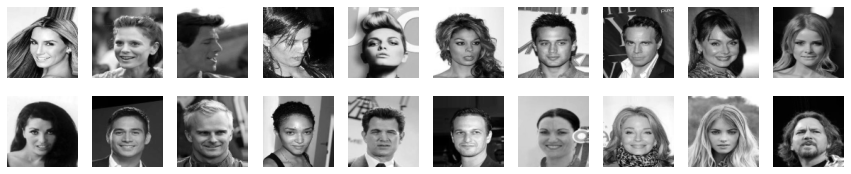

In [ ]:
#let us display the first 20 images in black and white
plt.figure(figsize=(15,3))
for k in range(20):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    #resize to 100x100
    im = resize(im, (100,100) )
    #transform to black and white by averaging the 3 color channels
    im = onp.mean(im, axis=2) # axis=2因为第三个通道是颜色通道
    #scale pixel intensity to [0,1] by divising by 255 and display
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap="gray") # 使用cmap="gray"，因为plt默认显示彩色，如果不指定显示灰色，则会报错
    plt.axis("off")

In [ ]:
#let us load the first 15000 images
n_img = 15000
img_array = onp.zeros((n_img, 100,100)) # 三维数组
for k in range(n_img):
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    im = resize(im, (100,100) )
    im = im/255
    im = onp.mean(im, axis=2) # average the last channel
    img_array[k,:,:] = im # 第二维和第三维是图像的宽度和高度，因为将所有元素赋值，所有只需要使用：即可

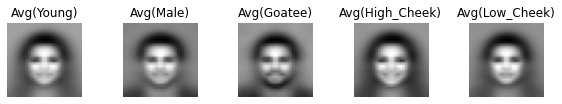

In [ ]:
#let us plot a few "average" faces
plt.figure(figsize=(10,3))

plt.subplot(2,5,1)
is_young = attribute["Young"][:n_img]==1
plt.imshow(onp.mean(img_array[is_young,:,:], axis=0), cmap="gray") # axis=0是指定对所有is_young图像求均值
plt.axis("off")
plt.title("Avg(Young)")

plt.subplot(2,5,2)
is_male = attribute["Male"][:n_img]==1
plt.imshow(onp.mean(img_array[is_male,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Male)")


plt.subplot(2,5,3)
is_Goatee = attribute["Goatee"][:n_img]==1
plt.imshow(onp.mean(img_array[is_Goatee,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Goatee)")


plt.subplot(2,5,4)
is_High_Cheekbones = attribute["High_Cheekbones"][:n_img]==1
plt.imshow(onp.mean(img_array[is_High_Cheekbones,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(High_Cheek)")


plt.subplot(2,5,5)
is_Low_Cheekbones = attribute["High_Cheekbones"][:n_img]==-1
plt.imshow(onp.mean(img_array[is_Low_Cheekbones,:,:], axis=0), cmap="gray")
plt.axis("off")
plt.title("Avg(Low_Cheek)")

#
#  FIGURE EXPORT:
#
# To export figures to include in the pdf report, you can use the 
# following command, making sure that dpi is high enough in order
# to export a figure with reasonable quality
# plt.savefig("high_quality_export.png", dpi=300)

In [ ]:
# let us compute the proportion of male images
proportion_male = np.mean(attribute["Male"].values==1) # .values将Series对象转换为Numpy数组
print(f"Proportion of Young people in the dataset: {100*proportion_male: .1f} %",  )

Proportion of Young people in the dataset:  42.2 %


In [ ]:
type(np.array(attribute['Male'][:1000])) # type输出类型

jaxlib.xla_extension.DeviceArray



# General Remarks

Your assignment consists in building an algorithm that can automatically tell whether an image corresponds to a Male or Female. 

1. You are only allowed to use (variants of) logistic regression models (possibly with regularization + feature engineering). In othe words, do not use deep-learning / convolutional-layers / etc.., that is not the purpose of this assignment
2. You can only use the first 15,000 images to train your models (note that you do not have to use all the 15,000 first images if you do not want to). The accuracy of your model will be evaluated on the last 5,000 images. The last 5,000 images constitute the test set.
3. You are allowed to use whatever optimization algorithm you think is most efficient.
4. You are allowed to do whatever pre-processing and feature engineering you deem appropriate.
5. You will report the accuracy (i.e. th percentage of correctly classified) on the test dataset (i.e. the last 5,000 images). 
6. You will as well report the Area Under the Curve (AUC) of your classifier on the test dataset.


# Specific Tasks
1. How does the accuracy (ie. tested on the last 5,000 images) depend on the size of the training set? Is it necessary to use all the training set, or does the accuracy stabilize before?
2. How does the accuracy depend on the resolution of the input image?
3. Is it necessary to use colored images (or black & white images are enough)? Is it helpful to increase the contrast of the images? Other preprocessing ideas?
4. What if one only uses the area around the eyes? Around the mouth? The hair? The ears? Etc..
5. Is it useful to use an ensemble of models (eg. for example, you can use a different model for each part of the face, and then try to find a way to ensemble these models)?
6. Report the error rate and AUC of your best model (when evaluated on the last 5,000 images)
7. Suppose now that you can only use 1% of the data, i.e. only the first 200 images, to train your model. What is the best model you can come up with? Is it helpful to use data-augmentation strategies? Is it helpful to use regularization strategies? Ensembling? Report the error rate and AUC of your best model (when evaluated on the last 5,000 images).


# Last Remark
A. Your code needs to be readable and **reproducible**. Make sure that it is possible to run the notebook to reproduce all the results presented in the pdf report. 
B. You need to submit two files: (1) a jupyter notebook with your code (2) a pdf report explaining your approaches and conclusions.  
C. Your report pdf report does not need to be long. It needs to describe the experiments that you have carried out, briefly detail the algorithms that you have used, include a few figures and outline the conclusions of your investigations. You can have a look at these (very good) machine-learning papers available [here](https://nips.cc/Conferences/2021/DatasetsBenchmarks/AcceptedPapers) although (indeed!) your report definitely does not need to be as long as these articles.  
D. You need to acknowledge carefully all the sources that you have used. 

# Feature Engineering

## Basic pre-processing

In [ ]:
from skimage.transform import rotate
from skimage.color import rgb2gray
import dlib
import numpy as np
import cv2
import pylab as plt
import imageio

In [ ]:
# grey scale
# rotation
def preprocessing(img):
    img = rgb2gray(img) # 将rgb转化为灰度图像
    if onp.round(onp.random.rand()*5,2) > 3.5:  # onp.random.rand()生成[0,1)范围内的随机数，onp.round用于四舍五入，第二个参数2表示两位小数  
        img = rotate(img,onp.round(onp.random.uniform(-5,5),2), resize = False)
        # 第二个参数为旋转角度，onp.random.uniform(-5,5)生成（-5,5）之间的随机数
        # resize=False表示不调整旋转后图像的大小。旋转可能会导致图像边界出现空白区域，但是在这里不会调整大小，因此这些空白区域可能会被保留在图像中。
    return img

## Crop the image

In [ ]:
# detect 68 key points
def key_points(img):
    PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector() # 使用dlib库中的人脸检测器检测输入图像中的人脸区域
    predictor = dlib.shape_predictor(PREDICTOR_PATH) # 导入预训练模型，可以检测人脸的关键点
    rects = detector(img, 1) # 应用detector(),1表示将输入图像进行上采样（即放大）一次后再进行检测，这样可以提高检测的准确率，但会增加计算时间和资源开销。
    # rects的每个元素是一个四元组(x, y, w, h)，表示一个检测到的人脸在输入图像中的位置和大小，其中(x, y)是人脸左上角的坐标，w和h分别是人脸的宽度和高度。注意，这里rects可能包含多个元素，因为一张图像中可能存在多个人脸。
    global landmarks # 全局变量
    for i in range(len(rects)):
        landmarks = np.matrix([[p.x, p.y] for p in predictor(img, rects[i]).parts()])
        # predictor(img, rects[i]).parts()返回一个包含68个关键点对象的列表，每个关键点对象都包含该点的横坐标x和纵坐标y
    return landmarks

In [ ]:
# crop mouth image
def cut_mouth(img):
    im = img.astype(np.uint8) # 转换格式为输入需要的
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # 转换为灰度图像，减少后续操作所需的计算量，同时也便于处理
    landmarks = key_points(im)
    mouth_points = []
    
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        if idx in [2, 8, 14, 33]:
            mouth_points.append(pos)
            
    left = mouth_points[0][0]
    jaw = mouth_points[1][1]
    right = mouth_points[2][0]
    nose = mouth_points[3][1]
    cropped = img[nose:jaw,left:right]
    
    return cropped

In [ ]:
# crop eyes image
def cut_eyes(img):
    im = img.astype(np.uint8)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    landmarks = key_points(im)
    mouth_points = []
    
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        if idx in [0, 29, 16, 24]:
            mouth_points.append(pos)
            
    left = mouth_points[0][0]
    lower = mouth_points[1][1]
    right = mouth_points[2][0]
    upper = mouth_points[3][1]
    cropped = img[(lower-15):(upper-5),left:(right+10)]
    return cropped

In [ ]:
# save the cropped image
'''
Time Consuming !!!
'''
path = "/Users/cainanguan/Desktop/2022Spring/DSA4212_Optimisation/Assignment/Assign1/data/img_celeba_small"
for k in range(390, 20000):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k]))
    #crop mouth img
    im_m = cut_mouth(im)
    #crop eyes img
    im_e = cut_eyes(im)
    #save cropped img
    try:
        cv2.imwrite('cropped_data/mouth/' +str(k+1)+".jpg", im_m)
        cv2.imwrite('cropped_data/eye/' +str(k+1)+".jpg", im_e)
    except:
        print('Problems: ', k)

# Logistic Regression

In [ ]:
# with regularization
# Maybe we can use the code of week5 and week 8 to construct the LR function
# Task1: crop the image, pre-processing, transform 2pc
# Task2: implement the logistic regression with regularization (SGD optimization) 2pc
# for AUC we can use sklearn, for image pre-processing, we can use skimage

That is equivalent to minimizing the function
$$
L(\beta) = \frac{1}{N} \sum_{i=1}^N \log\left[ 1+e^{-y_i \langle x_i, \beta \rangle} \right] + \frac{1}{N} \| \beta \|^2
$$


## Data Augmentation Methods

(200, 218, 178, 3)

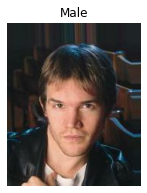

In [ ]:
# !!! MAKE SURE THAT THE LABELS ARE CORRECT !!!
plt.figure(figsize=(15,3))
size = 200
w = 178
h = 218
mini_image_set = onp.zeros((size, h, w, 3))
for k in range(size):
    #load image
    im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    #resize to 100x100 for display (you do not have to do this in the assignment)
    # im = resize(im, (100,100) )
    #scale pixel intensity to [0,1] by divising by 255 and display
    mini_image_set[k,:,:] = im
    
# Test  
plt.imshow(im/255.)
plt.axis("off")
is_male = attribute["Male"][k]
if is_male == 1:
    plt.title("Male")
else:
    plt.title("Female")
    
mini_image_set.shape

(4000, 28, 28, 3)

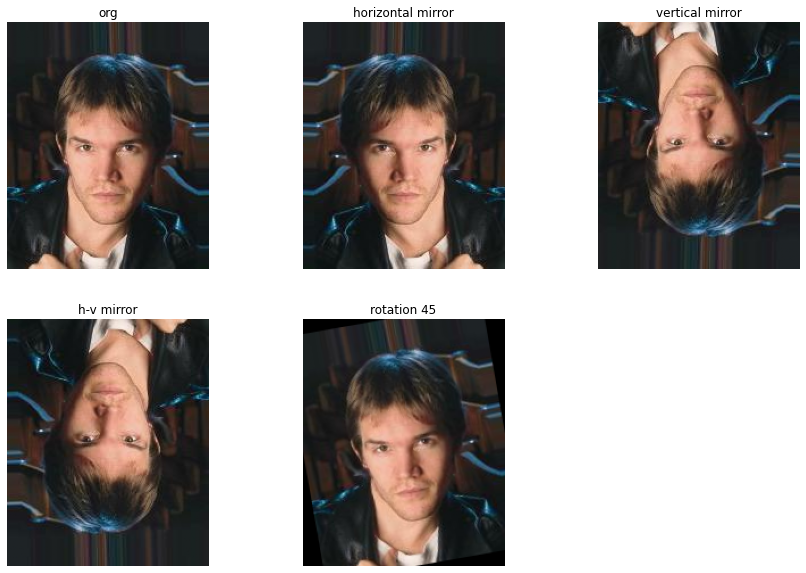

In [ ]:
# Random Rotation
# Horizontal mirror
h_flip = cv2.flip(img,1)
# vertical mirror
v_flip = cv2.flip(img,0)
# Horizontal - vertical
hv_flip = cv2.flip(img,-1)
# rotation
rows, cols, _ = img.shape
M = cv2.getRotationMatrix2D((cols/2, rows/2), 10, 1)
rotation_45 = cv2.warpAffine(img, M, (cols, rows))

M = cv2.getRotationMatrix2D((cols/2, rows/2), 20, 2)
rotation_135 = cv2.warpAffine(img, M,(cols, rows))

# show img
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1), plt.imshow(img/255)
plt.axis('off'); plt.title('org')
plt.subplot(2,3,2), plt.imshow(h_flip/255)
plt.axis('off'); plt.title('horizontal mirror')
plt.subplot(2,3,3), plt.imshow(v_flip/255)
plt.axis('off'); plt.title('vertical mirror')
plt.subplot(2,3,4), plt.imshow(hv_flip/255)
plt.axis('off'); plt.title('h-v mirror')
plt.subplot(2,3,5), plt.imshow(rotation_45/255)
plt.axis('off'); plt.title('rotation 45')
plt.show()

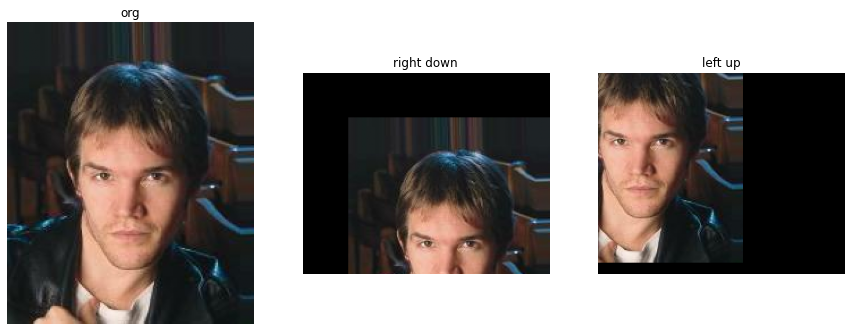

In [ ]:
# Shifting
mat_shift = np.float32([[1, 0, 40], [0, 1, 40]])
img_1 = cv2.warpAffine(img, mat_shift, (h, w))
mat_shift = np.float32([[1, 0, -50], [0, 1, -50]])
img_2 = cv2.warpAffine(img, mat_shift, (h, w))

## show
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1), plt.imshow(img/255)
plt.axis('off'); plt.title('org')
plt.subplot(1,3,2), plt.imshow(img_1/255)
plt.axis('off'); plt.title('right down')
plt.subplot(1,3,3), plt.imshow(img_2/255)
plt.axis('off'); plt.title('left up')
plt.show()

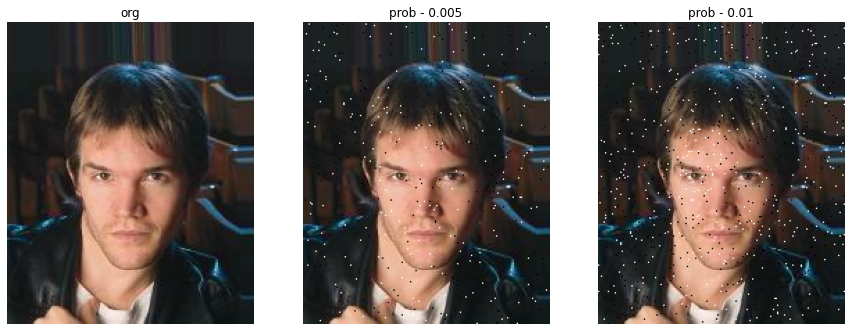

In [ ]:
# noise injection
def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

img_s1 = sp_noise(img, 0.005)
img_s2 = sp_noise(img, 0.01)
plt.figure(figsize=(15, 10))
plt.subplot(1,3,1), plt.imshow(img/255)
plt.axis('off'); plt.title('org')
plt.subplot(1,3,2), plt.imshow(img_s1/255)
plt.axis('off'); plt.title('prob - 0.005')
plt.subplot(1,3,3), plt.imshow(img_s2/255)
plt.axis('off'); plt.title('prob - 0.01')
plt.show()

Text(0.5, 1.0, 'change')

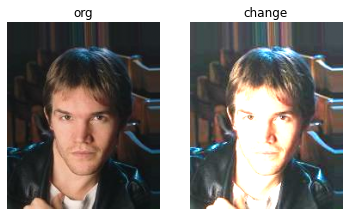

In [ ]:
# change color space
alpha = 2 # 1-3
beta = 10 # 0-100
image = img

new_image = np.zeros(image.shape, image.dtype)
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        for c in range(image.shape[2]):
            new_image[y,x,c] = np.clip(alpha * image[y,x,c] + beta, 0, 255)
            
plt.subplot(1,2,1), plt.imshow(image/255)
plt.axis('off'); plt.title('org')
plt.subplot(1,2,2), plt.imshow(new_image/255)
plt.axis('off'); plt.title('change')

In [ ]:
# Get Extended Dataset(4000)

# Random Crop
def random_crop(image, crop_shape, padding=None):
    img_h = image.shape[0]
    img_w = image.shape[1]
    img_d = image.shape[2]

    if padding:
        oshape_h = img_h + 2 * padding
        oshape_w = img_w + 2 * padding
        img_pad = np.zeros([oshape_h, oshape_w, img_d], np.uint8)
        img_pad[padding:padding+img_h, padding:padding+img_w, 0:img_d] = image
  
        nh = np.random.randint(0, oshape_h - crop_shape[0])
        nw = np.random.randint(0, oshape_w - crop_shape[1])
        image_crop = img_pad[nh:nh + crop_shape[0], nw:nw + crop_shape[1]]

        return image_crop
    else:
        print("WARNING!!! nothing to do!!!")
        return image
    
# noise injection
def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output


mini_image_set_augmented = onp.zeros((size * 20, 28, 28, 3))

for i in range(200):
    img = mini_image_set[i]
    img = resize(img, (36, 36, 3))
    # random crop (3)
    for j in range(3):
        mini_image_set_augmented[i * 20 + j, :, :, :] = random_crop(img, [28, 28], padding=1)
    
    
    img = resize(img, (28, 28, 3))
    h, w, _ = img.shape
    # Rotation(5)
    # Horizontal mirror
    mini_image_set_augmented[i * 20 + 3, :, :, :] = cv2.flip(img,1)
    # vertical mirror
    mini_image_set_augmented[i * 20 + 4, :, :, :] = cv2.flip(img,0)
    # Horizontal - vertical
    mini_image_set_augmented[i * 20 + 5, :, :, :] = cv2.flip(img,-1)
    # rotation
    rows, cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 10, 1) # 10 degree
    mini_image_set_augmented[i * 20 + 6, :, :, :] = cv2.warpAffine(img, M, (cols, rows))
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 20, 2) # 20
    mini_image_set_augmented[i * 20 + 7, :, :, :] = cv2.warpAffine(img, M,(cols, rows))
    
    # Shifting(4)
    mat_shift = np.float32([[1, 0, 5], [0, 1, 5]])
    mini_image_set_augmented[i * 20 + 8, :, :, :] = cv2.warpAffine(img, mat_shift, (h, w))
    mat_shift = np.float32([[1, 0, -5], [0, 1, -5]])
    mini_image_set_augmented[i * 20 + 9, :, :, :]  = cv2.warpAffine(img, mat_shift, (h, w))
    mat_shift = np.float32([[1, 0, 5], [0, 1, -5]])
    mini_image_set_augmented[i * 20 + 10, :, :, :] = cv2.warpAffine(img, mat_shift, (h, w))
    mat_shift = np.float32([[1, 0, -5], [0, 1, 5]])
    mini_image_set_augmented[i * 20 + 11, :, :, :] = cv2.warpAffine(img, mat_shift, (h, w))
    
    # Gaussian Noise(4)
    mini_image_set_augmented[i * 20 + 12, :, :, :] = sp_noise(img, 0.005)
    mini_image_set_augmented[i * 20 + 13, :, :, :] = sp_noise(img, 0.01)
    mini_image_set_augmented[i * 20 + 14, :, :, :] = sp_noise(img, 0.015)
    mini_image_set_augmented[i * 20 + 15, :, :, :] = sp_noise(img, 0.02)
    
    # Color space(4)
    alpha = 2 # 1-3
    beta = 10 # 0-100
    
    for j in range(4):
        # new_image = np.zeros(img.shape, img.dtype)
        for y in range(img.shape[0]):
            for x in range(img.shape[1]):
                for c in range(img.shape[2]):
                    alpha = 1 * j + 1 if j < 2 else 1 # 1-3
                    beta = 10 * j # 0-100
                    mini_image_set_augmented[i * 20 + 16 + j, y, x, c] = np.clip(alpha * img[y,x,c] + beta, 0, 255)
    
mini_image_set_augmented.shape

(4000, 28, 28, 3)

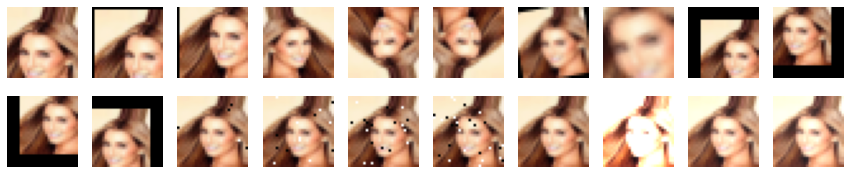

In [ ]:
# Show 20 data
plt.figure(figsize=(15,3))
for k in range(20):
    #load image
    im = mini_image_set_augmented[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255.)
    plt.axis("off")

In [ ]:
# Get Ys
Ys = []
for label in attribute['Male'][:200]:
    Ys += [label] * 20
Ys_test = list(attribute['Male'][15000:])
print(len(Ys_test))

# Construct X
resolution = 28
img_array_aug = onp.zeros((4000, resolution * resolution))
img_array_test = onp.zeros((5000, resolution * resolution))
for k in range(4000):
    im = mini_image_set_augmented[k]
    # scale
    im = resize(im, (resolution, resolution))
    #preprocessing
    im = onp.mean(im, axis=2)
    im = im.reshape(resolution * resolution)
    # Save imgs
    im = im / 255
    img_array_aug[k,:] = im

path = "/Users/cainanguan/Desktop/2022Spring/DSA4212_Optimisation/Assignment/Assign1/data/img_celeba_small"
for k in range(5000):
    im = imageio.imread(os.path.join(path, all_img[15000+k])).astype(float)
    # scale
    im = resize(im, (resolution, resolution))
    #preprocessing
    im = onp.mean(im, axis=2) # average 3 channel
    im = im.reshape(resolution * resolution)
    # Save imgs
    im = im / 255
    img_array_test[k,:] = im
    
img_array_test.shape

5000


(5000, 784)

In [ ]:
# predict by org images
classirfier_aug= LogisticRegression()
LR_aug = classirfier_aug.fit(img_array_aug, Ys)
y_label_preds_aug = LR_aug.predict(img_array_aug)

# predict by org
print('predict by augmentation -------------------')
print('Train Acc: ', jnp.mean(Ys == y_label_preds_aug))

y_label_preds_test_aug = LR_aug.predict(img_array_test)
acc_aug = jnp.mean(list(Ys_test) == y_label_preds_test_aug)
print('Test Acc: ', acc_aug)

predict by aug -------------------
Train Acc:  0.812
Test Acc:  0.7504000000000001


/Users/cainanguan/miniforge3/envs/jax_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Load Data (eye / mouth / original)

In [ ]:
# Load eyes images
path = "cropped_data/eye/"
all_img_e = [int(f[:-4]) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith(".jpg")]
all_img_e.sort()
all_img_e = list(map(lambda x:str(x) + '.jpg', all_img_e))

# load mouth images
path = "cropped_data/mouth/"
all_img_m = [int(f[:-4]) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f)) and f.endswith(".jpg") and f in all_img_e]
all_img_m.sort()
all_img_m = list(map(lambda x:str(x) + '.jpg', all_img_m))

nb_img_m = len(all_img_m)
print("Number of images:", nb_img_m)

# get all targets
idx_lst = []
for img in all_img_e:
    idx_lst.append(int(img[:-4]) - 1)
print("Number of idx:", len(idx_lst))
Ys = attribute.iloc[idx_lst]['Male']

Number of images: 18861
Number of idx: 18861


In [ ]:
# get oringinal pics
now_all_img = []
for idx in idx_lst:
    now_all_img.append(all_img[idx])
len(now_all_img)

18861

In [ ]:
# Load images
resolution = 28
path = "/Users/cainanguan/Desktop/2022Spring/DSA4212_Optimisation/Assignment/Assign1/data/img_celeba_small/"
path_m = "cropped_data/mouth/"
path_e = "cropped_data/eye/"

n_img = len(all_img_e)
img_array_m = onp.zeros((n_img, resolution, resolution))
img_array_e = onp.zeros((n_img, resolution, resolution))
img_array_original = onp.zeros((n_img, resolution, resolution))

for k in range(n_img):
    # im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
    # load cut eyes and mouths
    im_m = imageio.imread(os.path.join(path_m, all_img_m[k])).astype(float)
    im_e = imageio.imread(os.path.join(path_e, all_img_e[k])).astype(float)
    im_o = imageio.imread(os.path.join(path, now_all_img[k])).astype(float)
    
    # scale
    im_m = resize(im_m, (resolution, resolution))
    im_e = resize(im_e, (resolution, resolution))
    im_o = resize(im_o, (resolution, resolution))
    
    #preprocessing
    im_m = onp.mean(im_m, axis=2) # average 3 channel
    im_e = onp.mean(im_e, axis=2)
    im_o = onp.mean(im_o, axis=2)
    
    # Save imgs
    im_m = im_m / 255
    img_array_m[k,:,:] = im_m
    im_e = im_e / 255
    img_array_e[k,:,:] = im_e
    im_o = im_o / 255
    img_array_original[k,:,:] = im_o

# show img for test
# plt.imshow(im_m/255.)

## Split Dataset

In [ ]:
from collections import Counter
# Split Dataset
split_pos = 14000

# mouths
train_data_m = img_array_m[:split_pos].reshape(split_pos, resolution * resolution)
train_data_label_m = np.array(Ys[:split_pos])
test_data_m = img_array_m[split_pos:].reshape(len(all_img_e) - split_pos, resolution * resolution)
test_data_label_m = np.array(Ys[split_pos:])

# org
train_data_org = img_array_original[:split_pos].reshape(split_pos, -1)
train_data_label_org = np.array(Ys[:split_pos])
test_data_org = img_array_original[split_pos:].reshape(len(all_img_e) - split_pos, -1)
test_data_label_org = np.array(Ys[split_pos:])

# eyes
train_data_e = img_array_e[:split_pos].reshape(split_pos, resolution * resolution)
train_data_label_e = np.array(Ys[:split_pos])
test_data_e = img_array_e[split_pos:].reshape(len(all_img_e) - split_pos, resolution * resolution)
test_data_label_e = np.array(Ys[split_pos:])

print('Train data: ', train_data_m.shape)
print('test data:', test_data_m.shape)
Counter(test_data_label_e)

Train data:  (14000, 784)
test data: (4861, 784)


Counter({1: 2030, -1: 2831})

## LR in scikit-learn (For Comparison)

In [ ]:
from sklearn.linear_model import LogisticRegression

# predict by mouth
classirfier_m = LogisticRegression()
LR_m = classirfier_m.fit(train_data_m, train_data_label_m)
y_label_preds_m = LR_m.predict(train_data_m)

# predict by eye
classirfier_e = LogisticRegression()
LR_e = classirfier_e.fit(train_data_e, train_data_label_e)
y_label_preds_e = LR_e.predict(train_data_e)

# predict by org images
classirfier_org = LogisticRegression()
LR_org = classirfier_org.fit(train_data_org, train_data_label_org)
y_label_preds_org = LR_org.predict(train_data_org)

# predict solely by mouth
print('predict solely by mouth -------------------')
print('Train Acc: ', jnp.mean(train_data_label_m == y_label_preds_m))
y_label_preds_test_m = LR_m.predict(test_data_m)
acc_mouth = jnp.mean(test_data_label_m == y_label_preds_test_m)
print('Test Acc: ', acc_mouth)

# predict solely by eye
print('predict solely by eye -------------------')
print('Train Acc: ', jnp.mean(train_data_label_e == y_label_preds_e))
y_label_preds_test_e = LR_e.predict(test_data_e)
acc_eye = jnp.mean(test_data_label_e == y_label_preds_test_e)
print('Test Acc: ', acc_eye)

# predict by org
print('predict solely by org -------------------')
print('Train Acc: ', jnp.mean(train_data_label_e == y_label_preds_org))
y_label_preds_test_org = LR_org.predict(test_data_org)
acc_org = jnp.mean(test_data_label_e == y_label_preds_test_org)
print('Test Acc: ', acc_org)


/Users/cainanguan/miniforge3/envs/jax_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/cainanguan/miniforge3/envs/jax_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

predict solely by mouth -------------------
Train Acc:  0.8176428571428572
Test Acc:  0.8002468627854351
predict solely by eye -------------------
Train Acc:  0.8384285714285715
Test Acc:  0.8284303641226085
predict solely by org -------------------
Train Acc:  0.8967142857142858
Test Acc:  0.8915860933964205


In [ ]:
# ensemble (weighted average)
all_sum = acc_mouth + acc_eye + acc_org

probs_m = LR_m.predict_proba(test_data_m)
probs_e = LR_e.predict_proba(test_data_e)
probs_org =  LR_org.predict_proba(test_data_org)


result = probs_m[:, 1] * acc_mouth/all_sum + probs_e[:, 1] * acc_eye/all_sum + probs_org[:, 1] * acc_org/all_sum
result = list((map(lambda x: 1 if x > 0.5 else -1, result)))

result2 = probs_m[:, 1] * 1/3 + probs_e[:, 1] * 1/3 + probs_org[:, 1] * 1/3
result2 = list((map(lambda x: 1 if x > 0.5 else -1, result2)))

print('Ensemble Acc(Weighted Average): ', jnp.mean(test_data_label_e == result))
print('Ensemble Acc(Simple Average): ', jnp.mean(test_data_label_e == result2))


Ensemble Acc(Weighted Average):  0.9026949187409998
Ensemble Acc(Simple Average):  0.9002262908866488


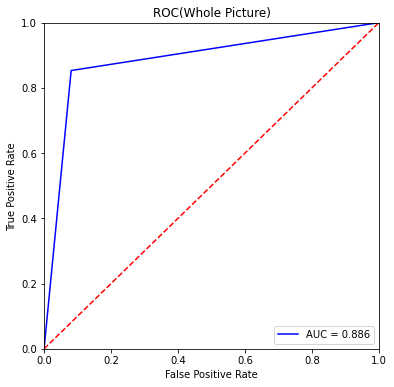

In [ ]:
# Test ROC (ensemble)
fpr, tpr, threshold = metrics.roc_curve(test_data_label_m, y_label_preds_test_org)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('ROC(Whole Picture)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Define Loss Function

In [ ]:
# choose loss function
reg = 0
# Compute the loss without regularization
def loss_single(beta, x, y):
    # L1 regulariztion
    if reg == 1: return jnp.log(1. + jnp.exp(-y * jnp.dot(beta, x))) + jnp.abs(beta)
    # L2 regulariztion
    elif reg == 2: return jnp.log(1. + jnp.exp(-y * jnp.dot(beta, x))) + jnp.dot(beta, beta)
    # No reg
    else: return jnp.log(1. + jnp.exp(-y * jnp.dot(beta, x)))

loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0))

def loss(beta, x, y):
    return jnp.mean(loss_batch(beta, x, y))
    # return jnp.sum(loss_batch(beta, x, y))
loss_grad = jax.jit(jax.grad(loss, argnums=0))
# compute the gradient and loss value at the same time
loss_value_and_grad = jax.jit(jax.value_and_grad(loss))

## Define Training Functions

In [ ]:
def loss_grad_wrapper(beta):
    """ compute the gradient of func at x and make sure that the output is a numpy array"""
    return onp.array(loss_grad(beta, train_data, train_data_label))

In [ ]:
def loss_(beta):
    return loss(beta, train_data, train_data_label)

In [ ]:
def prediction(beta, x):
    proba = 1. / (1. + jnp.exp(-jnp.dot(x, beta)))
    return proba

prediction_batch = jax.vmap(prediction, in_axes=(None, 0))

In [ ]:
@jax.jit
def compute_error_rate(beta, X, Y):
    pred_bool = prediction_batch(beta, X) > 0.5
    pred = 2 * pred_bool - 1
    return jnp.mean(Y == pred)

## Train model with SGD

In [ ]:
beta_init = np.random.normal(0, scale= 1 / np.sqrt(resolution * resolution), size=(resolution * resolution))

In [ ]:
# We train 3 LR models to predict mouths & eyes & orginals
'''
For Mouth
'''
beta_m = beta_init
n_epoch = 200
minibatch_size = 300
learning_rate = 0.05
train_data = train_data_m
train_data_label = train_data_label_m


N = len(train_data)  # total number of images
img_indices = np.arange(N) # for shuffle
loss_history = []
loss_history_end_epoch_m = []
print('Start Training: ')
for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    n_minibatch = N // minibatch_size + 1
    # randomize the batches
    np.random.shuffle(img_indices)
    all_loss_within_epoch = []

    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = train_data[batch_indices]
        Y_minibatch = train_data_label[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_value_and_grad(beta_m, X_minibatch, Y_minibatch)
        # do one step of SGD
        beta_m -= learning_rate * grad
        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)

    loss_history_end_epoch_m.append(np.mean(all_loss_within_epoch))
    err_train = 100 * compute_error_rate(beta_m, test_data_m, test_data_label_m)
    # err_val= 100 * compute_error_rate(beta, val_data, val_data_label)[0]
    print(f"iter:{epoch} \t Loss:{np.mean(all_loss_within_epoch) : 2.3f} \t acc:{err_train : 2.1f}% ")

Start Training: 
iter:0 	 Loss: 0.692 	 acc: 67.4% 
iter:1 	 Loss: 0.621 	 acc: 70.2% 
iter:2 	 Loss: 0.565 	 acc: 71.4% 
iter:3 	 Loss: 0.560 	 acc: 72.5% 
iter:4 	 Loss: 0.539 	 acc: 74.0% 
iter:5 	 Loss: 0.542 	 acc: 75.4% 
iter:6 	 Loss: 0.530 	 acc: 74.4% 
iter:7 	 Loss: 0.522 	 acc: 75.1% 
iter:8 	 Loss: 0.524 	 acc: 75.9% 
iter:9 	 Loss: 0.514 	 acc: 74.0% 
iter:10 	 Loss: 0.510 	 acc: 73.0% 
iter:11 	 Loss: 0.515 	 acc: 72.6% 
iter:12 	 Loss: 0.499 	 acc: 77.2% 
iter:13 	 Loss: 0.504 	 acc: 75.6% 
iter:14 	 Loss: 0.496 	 acc: 77.6% 
iter:15 	 Loss: 0.501 	 acc: 76.6% 
iter:16 	 Loss: 0.498 	 acc: 77.2% 
iter:17 	 Loss: 0.490 	 acc: 77.1% 
iter:18 	 Loss: 0.490 	 acc: 76.4% 
iter:19 	 Loss: 0.487 	 acc: 78.2% 
iter:20 	 Loss: 0.488 	 acc: 78.2% 
iter:21 	 Loss: 0.483 	 acc: 77.9% 
iter:22 	 Loss: 0.483 	 acc: 77.1% 
iter:23 	 Loss: 0.487 	 acc: 78.0% 
iter:24 	 Loss: 0.480 	 acc: 78.4% 
iter:25 	 Loss: 0.489 	 acc: 78.5% 
iter:26 	 Loss: 0.479 	 acc: 78.5% 
iter:27 	 Loss: 0.475

In [ ]:
'''
For eyes
'''
beta_e = beta_init
n_epoch = 200
minibatch_size = 300
learning_rate = 0.05
train_data = train_data_e
train_data_label = train_data_label_e


N = len(train_data)  # total number of images
img_indices = np.arange(N) # for shuffle
loss_history = []
loss_history_end_epoch_e = []
print('Start Training: ')
for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    n_minibatch = N // minibatch_size + 1
    # randomize the batches
    np.random.shuffle(img_indices)
    all_loss_within_epoch = []

    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = train_data[batch_indices]
        Y_minibatch = train_data_label[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_value_and_grad(beta_e, X_minibatch, Y_minibatch)
        # do one step of SGD
        beta_e -= learning_rate * grad
        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)

    loss_history_end_epoch_e.append(np.mean(all_loss_within_epoch))
    err_train = 100 * compute_error_rate(beta_e, test_data_e, test_data_label_e)
    # err_val= 100 * compute_error_rate(beta, val_data, val_data_label)[0]
    print(f"iter:{epoch} \t Loss:{np.mean(all_loss_within_epoch) : 2.3f} \t acc:{err_train : 2.1f}% ")

Start Training: 
iter:0 	 Loss: 0.798 	 acc: 44.8% 
iter:1 	 Loss: 0.669 	 acc: 65.1% 
iter:2 	 Loss: 0.648 	 acc: 71.2% 
iter:3 	 Loss: 0.575 	 acc: 72.7% 
iter:4 	 Loss: 0.567 	 acc: 73.8% 
iter:5 	 Loss: 0.536 	 acc: 67.3% 
iter:6 	 Loss: 0.530 	 acc: 74.1% 
iter:7 	 Loss: 0.534 	 acc: 75.6% 
iter:8 	 Loss: 0.538 	 acc: 63.0% 
iter:9 	 Loss: 0.521 	 acc: 72.7% 
iter:10 	 Loss: 0.505 	 acc: 77.1% 
iter:11 	 Loss: 0.502 	 acc: 79.7% 
iter:12 	 Loss: 0.508 	 acc: 70.8% 
iter:13 	 Loss: 0.500 	 acc: 79.5% 
iter:14 	 Loss: 0.493 	 acc: 79.4% 
iter:15 	 Loss: 0.491 	 acc: 72.2% 
iter:16 	 Loss: 0.488 	 acc: 75.5% 
iter:17 	 Loss: 0.486 	 acc: 79.2% 
iter:18 	 Loss: 0.490 	 acc: 72.5% 
iter:19 	 Loss: 0.478 	 acc: 80.5% 
iter:20 	 Loss: 0.482 	 acc: 78.4% 
iter:21 	 Loss: 0.475 	 acc: 78.5% 
iter:22 	 Loss: 0.471 	 acc: 80.9% 
iter:23 	 Loss: 0.474 	 acc: 81.0% 
iter:24 	 Loss: 0.470 	 acc: 79.6% 
iter:25 	 Loss: 0.468 	 acc: 79.8% 
iter:26 	 Loss: 0.468 	 acc: 79.9% 
iter:27 	 Loss: 0.472

In [ ]:
'''
For originals
'''
# beta_init_org = np.random.normal(0, scale= 1 / np.sqrt(3 * resolution * resolution), size=(3 * resolution * resolution))

beta_org = beta_init
n_epoch = 200
minibatch_size = 100
learning_rate = 0.05
train_data = train_data_org
train_data_label = train_data_label_org

N = len(train_data)  # total number of images
img_indices = np.arange(N) # for shuffle
loss_history = []
loss_history_end_epoch_org = []
print('Start Training: ')

for epoch in range(n_epoch):
    # go through all the minibatches, sequetially
    n_minibatch = N // minibatch_size + 1
    # randomize the batches
    np.random.shuffle(img_indices)
    all_loss_within_epoch = []

    for k in range(n_minibatch):
        # create the minibatch of examples
        batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
        batch_indices = img_indices[batch_indices]
        X_minibatch = train_data[batch_indices]
        Y_minibatch = train_data_label[batch_indices]

        # compute the stochastic gradient
        val, grad = loss_value_and_grad(beta_org, X_minibatch, Y_minibatch)
        # do one step of SGD
        beta_org -= learning_rate * grad
        # book-keeping
        loss_history.append(val)
        all_loss_within_epoch.append(val)

    loss_history_end_epoch_org.append(np.mean(all_loss_within_epoch))
    err_train = 100 * compute_error_rate(beta_org, test_data_org, test_data_label_org)
    # err_val= 100 * compute_error_rate(beta, val_data, val_data_label)[0]
    print(f"iter:{epoch} \t Loss:{np.mean(all_loss_within_epoch) : 2.3f} \t acc:{err_train : 2.1f}% ")

Start Training: 
iter:0 	 Loss: 0.639 	 acc: 67.5% 
iter:1 	 Loss: 0.608 	 acc: 70.0% 
iter:2 	 Loss: 0.580 	 acc: 69.9% 
iter:3 	 Loss: 0.563 	 acc: 69.0% 
iter:4 	 Loss: 0.550 	 acc: 72.9% 
iter:5 	 Loss: 0.544 	 acc: 74.0% 
iter:6 	 Loss: 0.535 	 acc: 74.6% 
iter:7 	 Loss: 0.527 	 acc: 75.4% 
iter:8 	 Loss: 0.520 	 acc: 74.9% 
iter:9 	 Loss: 0.512 	 acc: 74.7% 
iter:10 	 Loss: 0.505 	 acc: 76.0% 
iter:11 	 Loss: 0.505 	 acc: 71.8% 
iter:12 	 Loss: 0.505 	 acc: 77.1% 
iter:13 	 Loss: 0.496 	 acc: 75.6% 
iter:14 	 Loss: 0.492 	 acc: 75.8% 
iter:15 	 Loss: 0.486 	 acc: 69.7% 
iter:16 	 Loss: 0.482 	 acc: 78.6% 
iter:17 	 Loss: 0.481 	 acc: 79.2% 
iter:18 	 Loss: 0.473 	 acc: 78.4% 
iter:19 	 Loss: 0.467 	 acc: 74.6% 
iter:20 	 Loss: 0.467 	 acc: 78.9% 
iter:21 	 Loss: 0.463 	 acc: 77.0% 
iter:22 	 Loss: 0.464 	 acc: 79.9% 
iter:23 	 Loss: 0.464 	 acc: 79.6% 
iter:24 	 Loss: 0.457 	 acc: 79.9% 
iter:25 	 Loss: 0.457 	 acc: 80.4% 
iter:26 	 Loss: 0.448 	 acc: 73.9% 
iter:27 	 Loss: 0.452

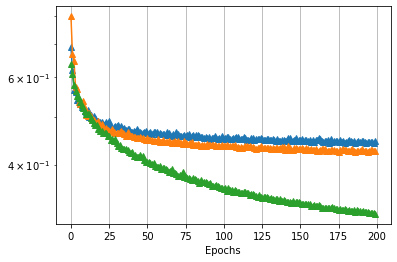

In [ ]:
# Show loss
plt.plot(loss_history_end_epoch_m, "-^")
plt.plot(loss_history_end_epoch_e, "-^")
plt.plot(loss_history_end_epoch_org, "-^")
plt.yscale("log")
plt.xlabel("Epochs")
plt.grid(True)

## Test Model Acc

In [ ]:
# Ensemble Train / Test accuracy
# train acc
probs_m_t = prediction_batch(beta_m, train_data_m)
probs_e_t = prediction_batch(beta_e, train_data_e)
probs_org_t = prediction_batch(beta_org, train_data_org)

result_t = probs_m_t * 1/3 + probs_e_t * 1/3 + probs_org_t * 1/3
result_t = list((map(lambda x: 1 if x > 0.5 else -1, result_t)))
print('Train Acc: ', jnp.mean(train_data_label_e == result_t))

# test acc
probs_m = prediction_batch(beta_m, test_data_m)
probs_e = prediction_batch(beta_e, test_data_e)
probs_org = prediction_batch(beta_org, test_data_org)

result = probs_m * 1/3 + probs_e * 1/3 + probs_org * 1/3
result = list((map(lambda x: 1 if x > 0.5 else -1, result)))
print('Test Acc: ', jnp.mean(test_data_label_e == result))


Train Acc:  0.8835000000000001
Test Acc:  0.8836393088552916


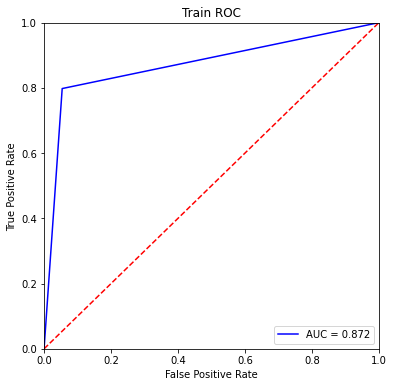

In [ ]:
# Train ROC
fpr, tpr, threshold = metrics.roc_curve(train_data_label_m, result_t)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Train ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

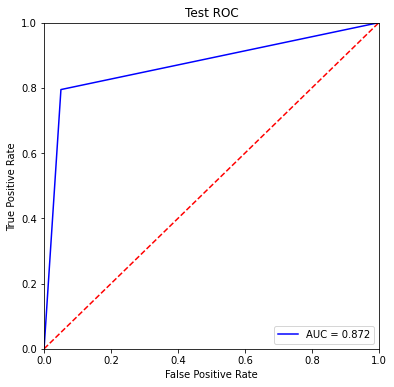

In [ ]:
# Test ROC
fpr, tpr, threshold = metrics.roc_curve(test_data_label_m, result)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Test ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Training with L-BFGS-B

In [ ]:
import time
import scipy
loss_history = []  #to save the loss trajectory
time_history = []  #to save the compute time
erro_history = []

def save_traj(beta):
    """ a function that saves a few statistics for later analysis"""
    loss_history.append(loss_(beta))
    time_history.append(time.time() - start)
    erro_history.append(compute_error_rate(beta, train_data, train_data_label)[0])


start = time.time()
traj = scipy.optimize.minimize(fun = loss_, #functino to minimize
                                x0 = onp.array(beta_init), #initial guess
                                method='L-BFGS-B',  #we want to use L-BFGS
                                jac=loss_grad_wrapper, #function that computes the gradient
                                callback=save_traj, #a function used to save some results for later pltting
                                options={"maxiter":2000})  #maximum number of iteration

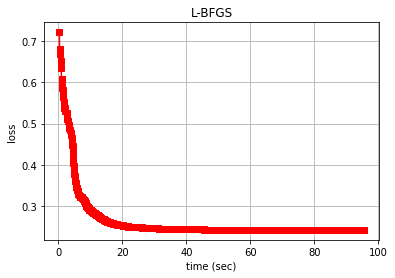

In [ ]:
plt.plot(time_history, loss_history, "r-s")
plt.xlabel("time (sec)")
plt.ylabel("loss")
plt.title("L-BFGS")
plt.grid(True)

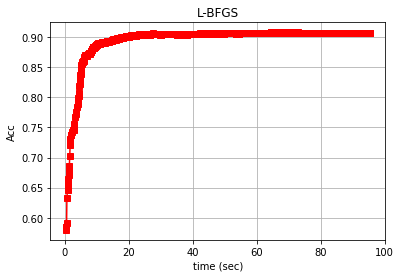

In [ ]:
plt.plot(time_history, erro_history, "r-s")
plt.xlabel("time (sec)")
plt.ylabel("Acc")
plt.title("L-BFGS")
plt.grid(True)

In [ ]:
# Average training accuracy
acc = np.mean(onp.array(erro_history))
acc

DeviceArray(0.90091911, dtype=float64)

## Test process

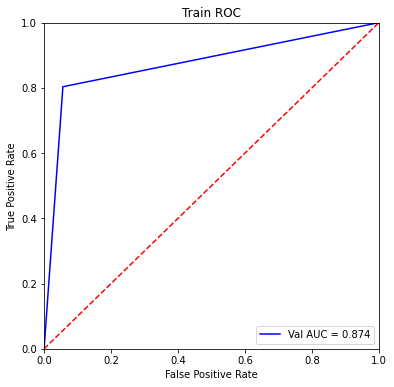

In [ ]:
# AUC曲线
fpr, tpr, threshold = metrics.roc_curve(train_data_label, preds_train)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.title('Train ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Define Our Own Logistic Regression Class(For convenient use)

In [ ]:
class MyLR:
    '''
    Params:
        resolution: image resolution
        reg: regulariztion methods
                0: no Reg
                1: L1 Reg
                2: L2 Reg
    '''
    def __init__(self, resolution=28, reg=0):
        self.beta = np.random.normal(0, scale= 1 / np.sqrt(resolution * resolution), size=(resolution * resolution))
        self.resoluton = resolution
        self.reg = reg
        
    # Renew beta params
    def renew_beta(self):
        self.beta = np.random.normal(0, scale= 1 / np.sqrt(self.resolution * self.resolution), size=(self.resolution * self.resolution))
        
    # compute batch loss
    def loss(self, beta, x, y):
        def loss_single(beta, x, y):
            # L1 regulariztion
            if self.reg == 1: return jnp.log(1. + jnp.exp(-y * jnp.dot(beta, x))) + jnp.abs(beta)
            # L2 regulariztion
            elif self.reg == 2: return jnp.log(1. + jnp.exp(-y * jnp.dot(beta, x))) + jnp.dot(beta, beta)
            # No reg
            else: return jnp.log(1. + jnp.exp(-y * jnp.dot(beta, x)))
        loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0))
        return jnp.mean(loss_batch(beta, x, y))
    
    # compute loss and grad
    def loss_value_and_grad(self, beta, x, y):
        # compute the gradient and loss value at the same time
        loss_value_and_grad = jax.jit(jax.value_and_grad(self.loss))
        return loss_value_and_grad(beta, x, y)
    
    def prediction(self, beta, x):
        proba = 1. / (1. + jnp.exp(-jnp.dot(x, beta)))
        return proba
    
    # prediction batch
    def prediction_batch(self, beta, x):
        prediction_batch =  jax.vmap(self.prediction, in_axes=(None, 0))
        return prediction_batch(beta, x)
    
    # SGD
    def train_with_sgd(self, n_epoch, minibatch_size, learning_rate, train_data, train_data_label):
        
        @jax.jit
        def compute_error_rate(beta, X, Y):
            pred_bool = self.prediction_batch(beta, X) > 0.5
            pred = 2 * pred_bool - 1
            return jnp.mean(Y == pred)
        
        N = len(train_data)  # total number of images
        img_indices = np.arange(N) # for shuffle
        loss_history = []
        loss_history_end_epoch = []
        print('Start Training: ')
        for epoch in range(n_epoch):
            # go through all the minibatches, sequetially
            n_minibatch = N // minibatch_size + 1
            # randomize the batches
            np.random.shuffle(img_indices)
            all_loss_within_epoch = []
            
            for k in range(n_minibatch):
                # create the minibatch of examples
                batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
                batch_indices = img_indices[batch_indices]
                X_minibatch = train_data[batch_indices]
                Y_minibatch = train_data_label[batch_indices]

                # compute the stochastic gradient
                val, grad = self.loss_value_and_grad(self.beta, X_minibatch, Y_minibatch)
                # do one step of SGD
                self.beta -= learning_rate * grad
                # book-keeping
                loss_history.append(val)
                all_loss_within_epoch.append(val)
            
            loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
            err_train = 100 * compute_error_rate(self.beta, train_data, train_data_label)
            # err_val= 100 * compute_error_rate(beta, val_data, val_data_label)[0]
            print(f"iter:{epoch} \t Loss:{np.mean(all_loss_within_epoch) : 2.3f} \t acc:{err_train : 2.1f}% ")
        return loss_history_end_epoch
    